In [1]:
import IJulia

# The julia kernel has built in support for Revise.jl, so this is the 
# recommended approach for long-running sessions:
# https://github.com/JuliaLang/IJulia.jl/blob/9b10fa9b879574bbf720f5285029e07758e50a5e/src/kernel.jl#L46-L51

# Users should enable revise within .julia/config/startup_ijulia.jl:
# https://timholy.github.io/Revise.jl/stable/config/#Using-Revise-automatically-within-Jupyter/IJulia-1

# clear console history
IJulia.clear_history()

fig_width = 7
fig_height = 5
fig_format = :retina
fig_dpi = 96

# no retina format type, use svg for high quality type/marks
if fig_format == :retina
  fig_format = :svg
elseif fig_format == :pdf
  fig_dpi = 96
  # Enable PDF support for IJulia
  IJulia.register_mime(MIME("application/pdf"))
end

# convert inches to pixels
fig_width = fig_width * fig_dpi
fig_height = fig_height * fig_dpi

# Intialize Plots w/ default fig width/height
try
  import Plots

  # Plots.jl doesn't support PDF output for versions < 1.28.1
  # so use png (if the DPI remains the default of 300 then set to 96)
  if (Plots._current_plots_version < v"1.28.1") & (fig_format == :pdf)
    Plots.gr(size=(fig_width, fig_height), fmt = :png, dpi = fig_dpi)
  else
    Plots.gr(size=(fig_width, fig_height), fmt = fig_format, dpi = fig_dpi)
  end
catch e
  # @warn "Plots init" exception=(e, catch_backtrace())
end

# Initialize CairoMakie with default fig width/height
try
  import CairoMakie
  
  CairoMakie.activate!(type = string(fig_format))
  CairoMakie.update_theme!(resolution=(fig_width, fig_height))
catch e
    # @warn "CairoMakie init" exception=(e, catch_backtrace())
end
  
# Set run_path if specified
try
  run_path = raw"/home/diego/local_repos/AGEC652_2024/slides/lecture_7_2"
  if !isempty(run_path)
    cd(run_path)
  end
catch e
  @warn "Run path init:" exception=(e, catch_backtrace())
end


# emulate old Pkg.installed beahvior, see
# https://discourse.julialang.org/t/how-to-use-pkg-dependencies-instead-of-pkg-installed/36416/9
import Pkg
function isinstalled(pkg::String)
  any(x -> x.name == pkg && x.is_direct_dep, values(Pkg.dependencies()))
end

# ojs_define
if isinstalled("JSON") && isinstalled("DataFrames")
  import JSON, DataFrames
  global function ojs_define(; kwargs...)
    convert(x) = x
    convert(x::DataFrames.AbstractDataFrame) = Tables.rows(x)
    content = Dict("contents" => [Dict("name" => k, "value" => convert(v)) for (k, v) in kwargs])
    tag = "<script type='ojs-define'>$(JSON.json(content))</script>"
    IJulia.display(MIME("text/html"), tag)
  end
elseif isinstalled("JSON")
  import JSON
  global function ojs_define(; kwargs...)
    content = Dict("contents" => [Dict("name" => k, "value" => v) for (k, v) in kwargs])
    tag = "<script type='ojs-define'>$(JSON.json(content))</script>"
    IJulia.display(MIME("text/html"), tag)
  end
else
  global function ojs_define(; kwargs...)
    @warn "JSON package not available. Please install the JSON.jl package to use ojs_define."
  end
end


# don't return kernel dependencies (b/c Revise should take care of dependencies)
nothing


In [2]:
#| include: false
using Pkg
Pkg.activate(".")
Pkg.instantiate()
# Pkg.add("Optim")
# Pkg.add("GLM")
# Pkg.add("LinearAlgebra")
# Pkg.add("Plots")
# Pkg.add("LaTeXStrings")
# Pkg.add("DataFrames")
# Pkg.add("CSV")

  Activating project at `~/local_repos/AGEC652_2024/slides/lecture_7_2`


In [3]:
using DataFrames, CSV
df = CSV.read("duopoly_shares_data.csv", DataFrame);
df[1:4, :] # First few rows

Row,MarketID,s_k,p_k,s_0,steel,labor,product
,Int64,Float64,Float64,Float64,Float64,Float64,String1
1,1,0.0349996,36.0954,0.897339,7.6,20.24,a
2,1,0.0676614,34.7954,0.897339,7.6,20.24,b
3,2,0.0430019,31.25,0.867155,8.83,21.91,a
4,2,0.0898428,33.24,0.867155,8.83,21.91,b


In [4]:
N = nrow(df); # Get number of rows
df.logsk_logs0 = log.(df.s_k) - log.(df.s_0); # Calculate LHS of demand equation
df.is_B = (df.product .== "b"); # Create dummy variable for product B
df[1:4,:]  # Check first rows

Row,MarketID,s_k,p_k,s_0,steel,labor,product,logsk_logs0,is_B
,Int64,Float64,Float64,Float64,Float64,Float64,String1,Float64,Bool
1,1,0.0349996,36.0954,0.897339,7.6,20.24,a,-3.2441,false
2,1,0.0676614,34.7954,0.897339,7.6,20.24,b,-2.58492,true
3,2,0.0430019,31.25,0.867155,8.83,21.91,a,-3.00397,false
4,2,0.0898428,33.24,0.867155,8.83,21.91,b,-2.26716,true


In [5]:
X = [ones(N) df.p_k df.is_B];
Z = [ones(N) df.is_B df.steel df.labor];

In [6]:
function g_i(θ)
    # DEMAND SIDE
    θ_d = θ[1:3] # Demand parameters
    # Epsilons for demand side
    ϵ_d = df.logsk_logs0 - (X * θ_d) 
    # Moment conditions for demand side
    m_di = Z .* ϵ_d

    # SUPPLY SIDE
    # Calculate implied costs
    α = -θ[2] # We need it to recover costs
    c_k = df.p_k - 1/α .* 1 ./(1 .- df.s_k)

    θ_s = θ[4:7] # Supply parameters
    # Epsilons for supply side
    ϵ_s = c_k - (Z * θ_s)
    # Moment conditions for supply side
    m_si = Z .* ϵ_s
  
    # Return matrices side by side (N x M)
    return([m_di m_si])
end;

In [7]:
function g_N(θ)
  # Get moment vectors
  g_is = g_i(θ)
  # Take means of each column and return
  return [sum(g_is[:, k]) for k in 1:M] ./ N
end;

In [8]:
using LinearAlgebra
M = 8 # Eight moment conditions
W_0 = I(M) # Identity Matrix
function Q(θ; W = W_0)
    # Get g_N
    m_i = g_i(θ)
    G = g_N(θ)
    # Calculate Q    
    G' * W * G
end;

In [9]:
using GLM
# OLS regression to get initial guess
ols_reg = lm(@formula(logsk_logs0 ~ 1 + p_k + is_B), df);
θ_0 = [coef(ols_reg); minimum(df.p_k); ones(3)./10];
θ_0'

1×7 adjoint(::Vector{Float64}) with eltype Float64:
 0.59417  -0.102303  0.611992  29.5715  0.1  0.1  0.1

In [10]:
# Step 1
using Optim
res = Optim.optimize(Q, θ_0, Newton(), Optim.Options(f_abstol=1e-10, g_abstol=0.0, g_reltol=0.0))
θ_1 =  res.minimizer;
θ_1'

1×7 adjoint(::Vector{Float64}) with eltype Float64:
 0.607455  -0.102708  0.612948  18.7229  0.215997  0.2718  0.154902

In [11]:
# Calculate W_hat (note that g_i transposed gs)
W_1 = inv(g_i(θ_1)'  * g_i(θ_1) ./N)

8×8 Matrix{Float64}:
 22645.8      -115.444     …  -23.0081     -5.69782     1.41266
  -115.444     177.383         -2.95534     0.226009    0.885507
  -447.324       1.85469        0.179547    0.400217    0.262554
  -857.543       0.832448       0.896556    0.120697   -0.194816
    30.8689    -22.9306         1.1218     -1.97982    -6.6906
   -23.0081     -2.95534   …    2.02458    -0.162135   -0.0151455
    -5.69782     0.226009      -0.162135    0.291764   -0.0127074
     1.41266     0.885507      -0.0151455  -0.0127074   0.308547

In [12]:
# Use step 1 estimates as initial guess
res = Optim.optimize(θ ->  Q(θ; W = W_1), θ_1, Newton(), Optim.Options(f_abstol=1e-10, g_abstol=0.0, g_reltol=0.0))
θ_GMM =  res.minimizer;
θ_GMM'

1×7 adjoint(::Vector{Float64}) with eltype Float64:
 1.40765  -0.125865  0.625764  20.5884  0.272487  0.268921  0.157183

In [13]:
using ForwardDiff
D_hat = ForwardDiff.jacobian(g_N, θ_GMM)

8×7 Matrix{Float64}:
  -1.0        -34.8071   -0.5      …    0.0         0.0         0.0
  -0.5        -17.5489   -0.5           0.0         0.0         0.0
  -7.92233   -275.985    -3.96117       0.0         0.0         0.0
 -22.0095    -766.231   -11.0048        0.0         0.0         0.0
   0.0        -67.5142    0.0          -0.5        -7.92233   -22.0095
   0.0        -34.3497    0.0      …   -0.5        -3.96117   -11.0048
   0.0       -534.769     0.0          -3.96117   -63.6728   -174.367
   0.0      -1485.86      0.0         -11.0048   -174.367    -485.441

In [14]:
# Again, note that function g_i transposed gs
S_hat = g_i(θ_GMM)'  * g_i(θ_GMM) ./N

8×8 Matrix{Float64}:
 0.0275799  0.0148271   0.219691  …   0.0569681    0.477954     1.36161
 0.0148271  0.0148271   0.11799       0.0569681    0.455911     1.25359
 0.219691   0.11799     1.77132       0.455911     3.83595     10.7673
 0.610723   0.327387    4.86297       1.25359     10.7673      30.796
 0.0603548  0.0569681   0.477954      0.7919      24.8241      69.3622
 0.0569681  0.0569681   0.455911  …   0.7919       6.52782     17.4691
 0.477954   0.455911    3.83595       6.52782    198.896      545.93
 1.36161    1.25359    10.7673       17.4691     545.93      1528.23

In [15]:
V_hat = inv(D_hat' * inv(S_hat) * D_hat) ./N

7×7 Matrix{Float64}:
  0.589969    -0.0171114     0.0102114    …  -0.0111672    -0.00706478
 -0.0171114    0.000496365  -0.00029865       0.000323367   0.00020736
  0.0102114   -0.00029865    0.000362985     -0.000161154  -0.00021899
  1.37476     -0.0399278     0.0258215       -0.0925723    -0.126748
  0.0430182   -0.00124802    0.00114213       0.00154853    0.000346637
 -0.0111672    0.000323367  -0.000161154  …   0.00717999    0.000583857
 -0.00706478   0.00020736   -0.00021899       0.000583857   0.00489292

In [16]:
SEs = sqrt.(diag(V_hat))

7-element Vector{Float64}:
 0.7680945658020922
 0.02227924751097748
 0.019052168140131397
 2.4909536105180057
 0.15461963032865925
 0.08473482409446073
 0.06994941649432838

In [17]:
using DataFrames, Distributions
results_df = DataFrame(
  Coefficient = ["β_0", "-α", "β_1", "γ_0", "γ_1", "γ_2", "γ_3"],
  Estimate = θ_GMM,
  StdError = SEs,
  CI_lower = θ_GMM .+ quantile(Normal(), 0.025) .* SEs,
  CI_upper = θ_GMM .+ quantile(Normal(), 0.975) .* SEs
)

println(results_df)

7×5 DataFrame
 Row │ Coefficient  Estimate   StdError   CI_lower    CI_upper   
     │ String       Float64    Float64    Float64     Float64    
─────┼───────────────────────────────────────────────────────────
   1 │ β_0           1.40765   0.768095   -0.0977856   2.91309
   2 │ -α           -0.125865  0.0222792  -0.169531   -0.0821984
   3 │ β_1           0.625764  0.0190522   0.588422    0.663106
   4 │ γ_0          20.5884    2.49095    15.7063     25.4706
   5 │ γ_1           0.272487  0.15462    -0.0305621   0.575536
   6 │ γ_2           0.268921  0.0847348   0.102843    0.434998
   7 │ γ_3           0.157183  0.0699494   0.0200844   0.294281


In [18]:
α_hat = -θ_GMM[2];
df.c_k = df.p_k - 1/α_hat .* 1 ./(1 .- df.s_k);

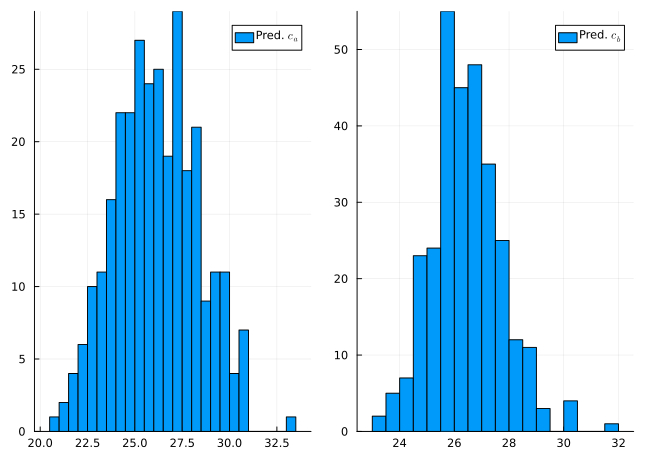

In [19]:
using Plots, LaTeXStrings
plot(histogram(df.c_k[.!df.is_B], label=L"Pred. $c_a$", bins=30), histogram(df.c_k[df.is_B], label=L"Pred. $c_b$", bins=30))

In [20]:
df.lerner_k = (df.p_k - df.c_k) ./ df.p_k;
# Firm A
mean_lerner_a = sum(df.lerner_k[.!df.is_B])./(N/2);
# Firm B
mean_lerner_b = sum(df.lerner_k[df.is_B])./(N/2);
println("The mean Lerner index of firm A is $(round(mean_lerner_a, digits=4)) and for firm B is $(round(mean_lerner_b, digits=4))")

The mean Lerner index of firm A is 0.2429 and for firm B is 0.2467
